In [1]:
import scipy.io
import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns

import utils as util

In [2]:
def get_acq_dir(sessionid, assay_prefix='single_20mm*', rootdir='/mnt/sda/Videos'):

    acquisition_dirs = sorted([f for f in glob.glob(os.path.join(rootdir, '%s*' % assay_prefix, 
                            '%s*' % sessionid)) if os.path.isdir(f)], key=util.natsort)
    #print("Found %i acquisitions from %s" % (len(acquisition_dirs), sessionid))
    assert len(acquisition_dirs)==1, "Unable to find unique acq. from session ID: %s" % sessionid
    acq_dir = acquisition_dirs[0]
    acquisition = os.path.split(acq_dir)[-1]

    return acq_dir

def add_frame_nums(trackdf, fps=None):
    frame_ixs = trackdf[trackdf['id']==0].index.tolist()
    trackdf['frame'] = None
    for i, g in trackdf.groupby('id'):
        trackdf.loc[g.index, 'frame'] = frame_ixs
    
    # add sec
    if fps is not None:
        trackdf['sec'] = trackdf['frame']/float(fps)
    
    return trackdf

In [3]:
rootdir = '/mnt/sda/Videos'
assay_prefix='single_20mm'
#sessionid = '20220128-1555'
sessionid = '20220202-1415'

In [4]:
rootdir

'/mnt/sda/Videos'

In [5]:
acq_dir = get_acq_dir(sessionid, assay_prefix=assay_prefix)
acquisition = os.path.split(acq_dir)[-1]
print('Processing acq: %s' % acquisition)

Processing acq: 20220202-1415_sant_7do_sh


## Load data

In [6]:
#%% Get corresponding calibration file
calib = util.load_calibration(acq_dir)

#% Load feature mat
featdf = util.load_feat(acq_dir)
trackdf = util.load_tracks(acq_dir)

In [7]:
trackdf = add_frame_nums(trackdf, fps=calib['FPS'])
featdf = add_frame_nums(featdf, fps=calib['FPS'])


#### Transform coordinates

In [8]:
featdf.head()

,vel,ang_vel,min_wing_ang,max_wing_ang,mean_wing_length,axis_ratio,fg_body_ratio,contrast,dist_to_wall,dist_to_other,angle_between,facing_angle,leg_dist,id,fpath,frame,sec
0,0.653376,0.136435,0.117636,0.166885,1.736628,2.960007,3.070059,0.135835,4.890425,4.303595,2.704543,2.324288,1.486153,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,0,0.0
1,0.653376,0.254105,0.119969,0.157462,1.734013,2.965182,3.066235,0.137416,4.869661,4.316939,2.699552,2.318317,1.504563,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,1,0.025
2,0.716899,0.486287,0.118082,0.161584,1.731338,2.959623,3.036756,0.137148,4.848897,4.337473,2.689465,2.306876,1.534010,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,2,0.05
3,0.227498,0.623332,0.121239,0.163795,1.725034,2.950147,3.007959,0.133861,4.848897,4.348107,2.685030,2.300470,1.556064,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,3,0.075
4,0.751505,0.719404,0.123654,0.158006,1.722225,2.950783,2.994506,0.131514,4.859981,4.337585,2.694603,2.312164,1.533975,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,4,0.1


In [9]:
trackdf.head()

,pos_x,pos_y,ori,major_axis_len,minor_axis_len,body_area,fg_area,img_contrast,min_fg_dist,wing_l_x,...,leg_1_ang,leg_2_ang,leg_3_ang,leg_4_ang,leg_5_ang,leg_6_ang,id,fpath,frame,sec
0,1063.156588,995.261308,-1.348977,126.311775,42.672798,4068.0,12489.0,0.135835,101.000000,1051.0,...,-2.966116,-2.393130,-1.330949,0.148199,1.142008,2.380438,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,0,0.0
1,1063.805514,996.008693,-1.352387,125.722703,42.316050,4026.0,12428.0,0.137204,102.000000,1053.0,...,-2.977059,-2.394153,-1.314264,1.136264,2.370047,2.925777,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,1,0.025
2,1064.723675,997.159052,-1.367565,126.559160,42.776117,4093.0,12365.0,0.139422,104.004807,1054.0,...,-2.972491,-2.372149,-1.291337,1.137500,2.352332,2.984578,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,2,0.05
3,1065.412354,997.807373,-1.382427,126.522162,42.886418,4096.0,12362.0,0.132545,107.000000,1058.0,...,-2.972541,-2.352322,-1.282848,1.145316,2.386282,2.989052,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,3,0.075
4,1064.349723,996.293324,-1.364996,127.117705,43.213661,4149.0,12342.0,0.130930,105.000000,1055.0,...,-2.986946,-2.375428,-1.307082,1.146425,2.345626,2.931173,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,4,0.1


In [10]:
featdf.columns

Index(['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length',
       'axis_ratio', 'fg_body_ratio', 'contrast', 'dist_to_wall',
       'dist_to_other', 'angle_between', 'facing_angle', 'leg_dist', 'id',
       'fpath', 'frame', 'sec'],
      dtype='object')

In [11]:
trackdf.columns

Index(['pos_x', 'pos_y', 'ori', 'major_axis_len', 'minor_axis_len',
       'body_area', 'fg_area', 'img_contrast', 'min_fg_dist', 'wing_l_x',
       'wing_l_y', 'wing_r_x', 'wing_r_y', 'wing_l_ang', 'wing_l_len',
       'wing_r_ang', 'wing_r_len', 'leg_1_x', 'leg_1_y', 'leg_2_x', 'leg_2_y',
       'leg_3_x', 'leg_3_y', 'leg_4_x', 'leg_4_y', 'leg_5_x', 'leg_5_y',
       'leg_6_x', 'leg_6_y', 'leg_1_ang', 'leg_2_ang', 'leg_3_ang',
       'leg_4_ang', 'leg_5_ang', 'leg_6_ang', 'id', 'fpath', 'frame', 'sec'],
      dtype='object')

#### Select 1 fly

In [12]:
fly_id = 0
feat = featdf[featdf['id']==fly_id].copy()
trk = trackdf[trackdf['id']==fly_id].copy()

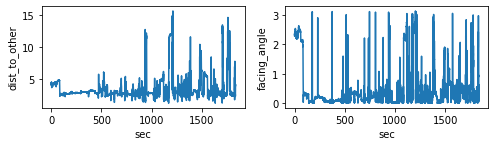

In [13]:
fig, axn = pl.subplots(1, 2, figsize=(8,4))
plot_params=['dist_to_other', 'facing_angle']
for ax, param in zip(axn.flat, plot_params):
    sns.lineplot(x='sec', y=param, data=feat, ax=ax)
    ax.set_box_aspect(0.5)


In [14]:
calib

{'n_chambers': 1,
 'n_rows': 1,
 'n_cols': 1,
 'FPS': 40,
 'PPM': 67.96070885563215,
 'centroids': array([776, 776], dtype=uint16),
 'w': 1512,
 'h': 1512,
 'rois': array([  55,  101, 1397, 1388], dtype=uint16),
 'n_flies': 2}

#### Identify bouts

In [15]:
ppm = calib['PPM']
fps = calib['FPS']

male_id=0
female_id=1

# interaction params:
interaction_dist_mm = 5
max_dist_to_other = interaction_dist_mm #* ppm
max_facing_angle=80
fly_id = 0
# -----------------------------------------

In [16]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [17]:
feat = util.threshold_courtship_bouts(feat, max_dist_to_other=max_dist_to_other, max_facing_angle=max_facing_angle)
feat.columns

Index(['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length',
       'axis_ratio', 'fg_body_ratio', 'contrast', 'dist_to_wall',
       'dist_to_other', 'angle_between', 'facing_angle', 'leg_dist', 'id',
       'fpath', 'frame', 'sec', 'courtship', 'facing_angle_deg'],
      dtype='object')

<AxesSubplot:xlabel='sec', ylabel='courtship'>

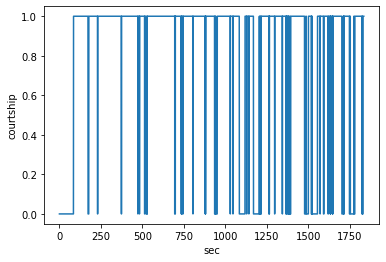

In [18]:
pl.figure()
sns.lineplot(x='sec', y='courtship', data=feat)

In [19]:
ibi_min_sec=5
feat, bout_dict = util.get_true_bouts(feat, calib, ibi_min_sec=ibi_min_sec)
print("Found %i bouts, with min. IBI=%.2f sec" % (len(bout_dict), ibi_min_sec))

0 4.675
1 0.975
2 1.2
3 0.7
4 0.05
5 0.075
6 0.05
7 0.05
8 0.125
9 6.475
10 0.075
11 0.05
12 0.075
13 0.225
14 0.05
15 0.075
16 4.05
17 0.15
18 0.525
19 0.175
20 0.075
21 1.8
22 2.875
23 0.125
24 8.925
25 0.275
26 0.05
27 34.475
28 0.2
29 0.7
30 0.075
31 35.475
32 3.35
33 4.125
34 1.15
35 0.05
36 0.05
37 0.325
38 0.2
39 0.3
40 0.525
41 0.475
42 0.15
43 1.025
44 0.125
45 0.075
46 0.375
47 0.9
48 0.425
49 0.55
50 5.025
51 5.0
52 3.875
53 8.15
54 0.225
55 12.575
56 2.25
57 1.05
58 33.1
59 0.075
60 0.425
61 3.075
62 1.625
63 0.6
64 0.15
65 0.15
66 0.675
67 8.725
68 1.175
69 0.525
70 1.7
71 21.275
72 4.7
73 0.15
74 4.05
Found 9 bouts, with min. IBI=5.00 sec


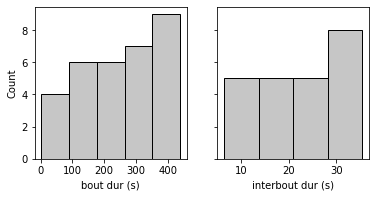

In [20]:
hist_c = [0.7]*3
plot_cdf=True

bouts = [b for i, b in bout_dict.items()]

bout_durs = [(b[-1]-b[0]+1)/fps for b in bouts]
ibi_durs = np.array([(bouts[i+1][0] - b[-1])/fps for i, b in enumerate(bouts[0:-1])])

fig, axn = pl.subplots(1, 2, sharey=True)
sns.histplot(bout_durs, ax=axn[0], color=hist_c, cumulative=plot_cdf)
axn[0].set_xlabel('bout dur (s)')
sns.histplot(ibi_durs, ax=axn[1], color=hist_c, cumulative=plot_cdf)
axn[1].set_xlabel('interbout dur (s)')
for ax in axn:
    ax.set_box_aspect(1)


# Wing extensions

In [21]:

def plot_wing_extensions(trk, start_frame=0, end_frame=None, ax=None, figsize=(20,3),
                         c1='lightblue', c2='steelblue', l1='var1', l2='var2', xaxis='sec'):
    if ax is None:
        fig, ax = pl.subplots(figsize=figsize)
    if end_frame is None:
        end_frame = int(trk.index.tolist()[-1])
    bout_dur_sec = (end_frame-start_frame)/fps
    df_ = trk.loc[start_frame:end_frame]
    ax.plot(df_[xaxis], np.rad2deg(df_['wing_r_ang']), color=c1, label=l1)
    ax.plot(df_[xaxis], np.rad2deg(df_['wing_l_ang']), color=c2, label=l2)

    return ax

In [22]:
import plotting as plotutils

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Current bout: 7.29min
Current bout: 6.90min
Current bout: 2.22min
Current bout: 0.85min
Current bout: 4.54min
Current bout: 0.04min
Current bout: 0.36min
Current bout: 2.45min
Current bout: 0.70min


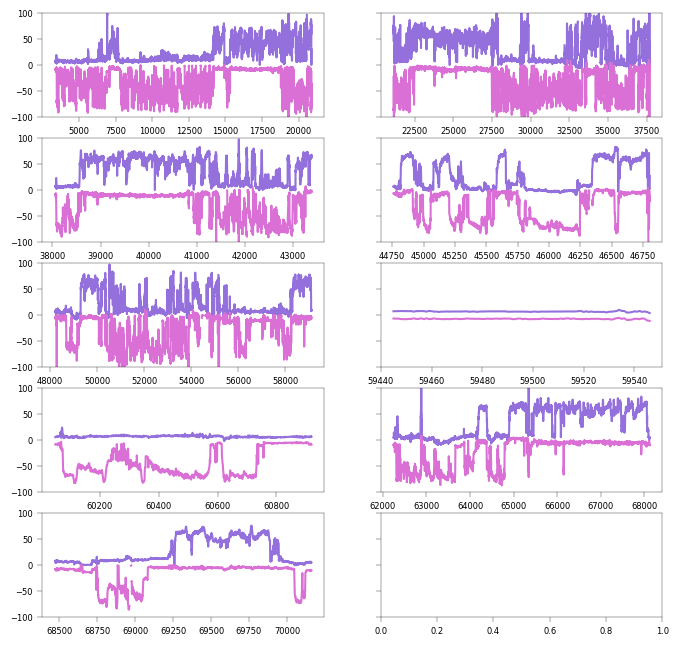

In [23]:
cdict = {'wing_r': 'mediumpurple',
        'wing_l': 'orchid'}
plotutils.set_plot_params(light=False) #lw_axes=1, axis_labelsize=12, tick_labelsize=10, color=[0.7]*3, dpi=300)

fig, axn = pl.subplots(5, 2, figsize=(8,8), sharey=True)

curr_bout= bouts[0]

for ai, curr_bout in enumerate(bouts):
    bout_dur_sec = (curr_bout[-1]-curr_bout[0])/fps
    print("Current bout: %.2fmin" % (bout_dur_sec/60.) )
    start_frame, end_frame = curr_bout[0], curr_bout[-1]
    df_ = trk.loc[start_frame:end_frame]

    # plot
    ax = axn.flatten()[ai]

    ax.plot(np.rad2deg(df_['wing_r_ang']), color=cdict['wing_r'], label='wing_r')
    ax.plot(np.rad2deg(df_['wing_l_ang']), color=cdict['wing_l'], label='wing_l')
    ax.set_ylim([-100, 100])
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right')


In [24]:
importlib.reload(plotutils)
plotutils.set_plot_params(light=True, default_sizes=False, axis_labelsize=24, tick_labelsize=18) #lw_axes=1, axis_labelsize=12, tick_labelsize=10, color=[0.7]*3, dpi=300)


In [25]:
feat['angle_between_deg'] = np.rad2deg(feat['angle_between'])


start/end: 3382 20877


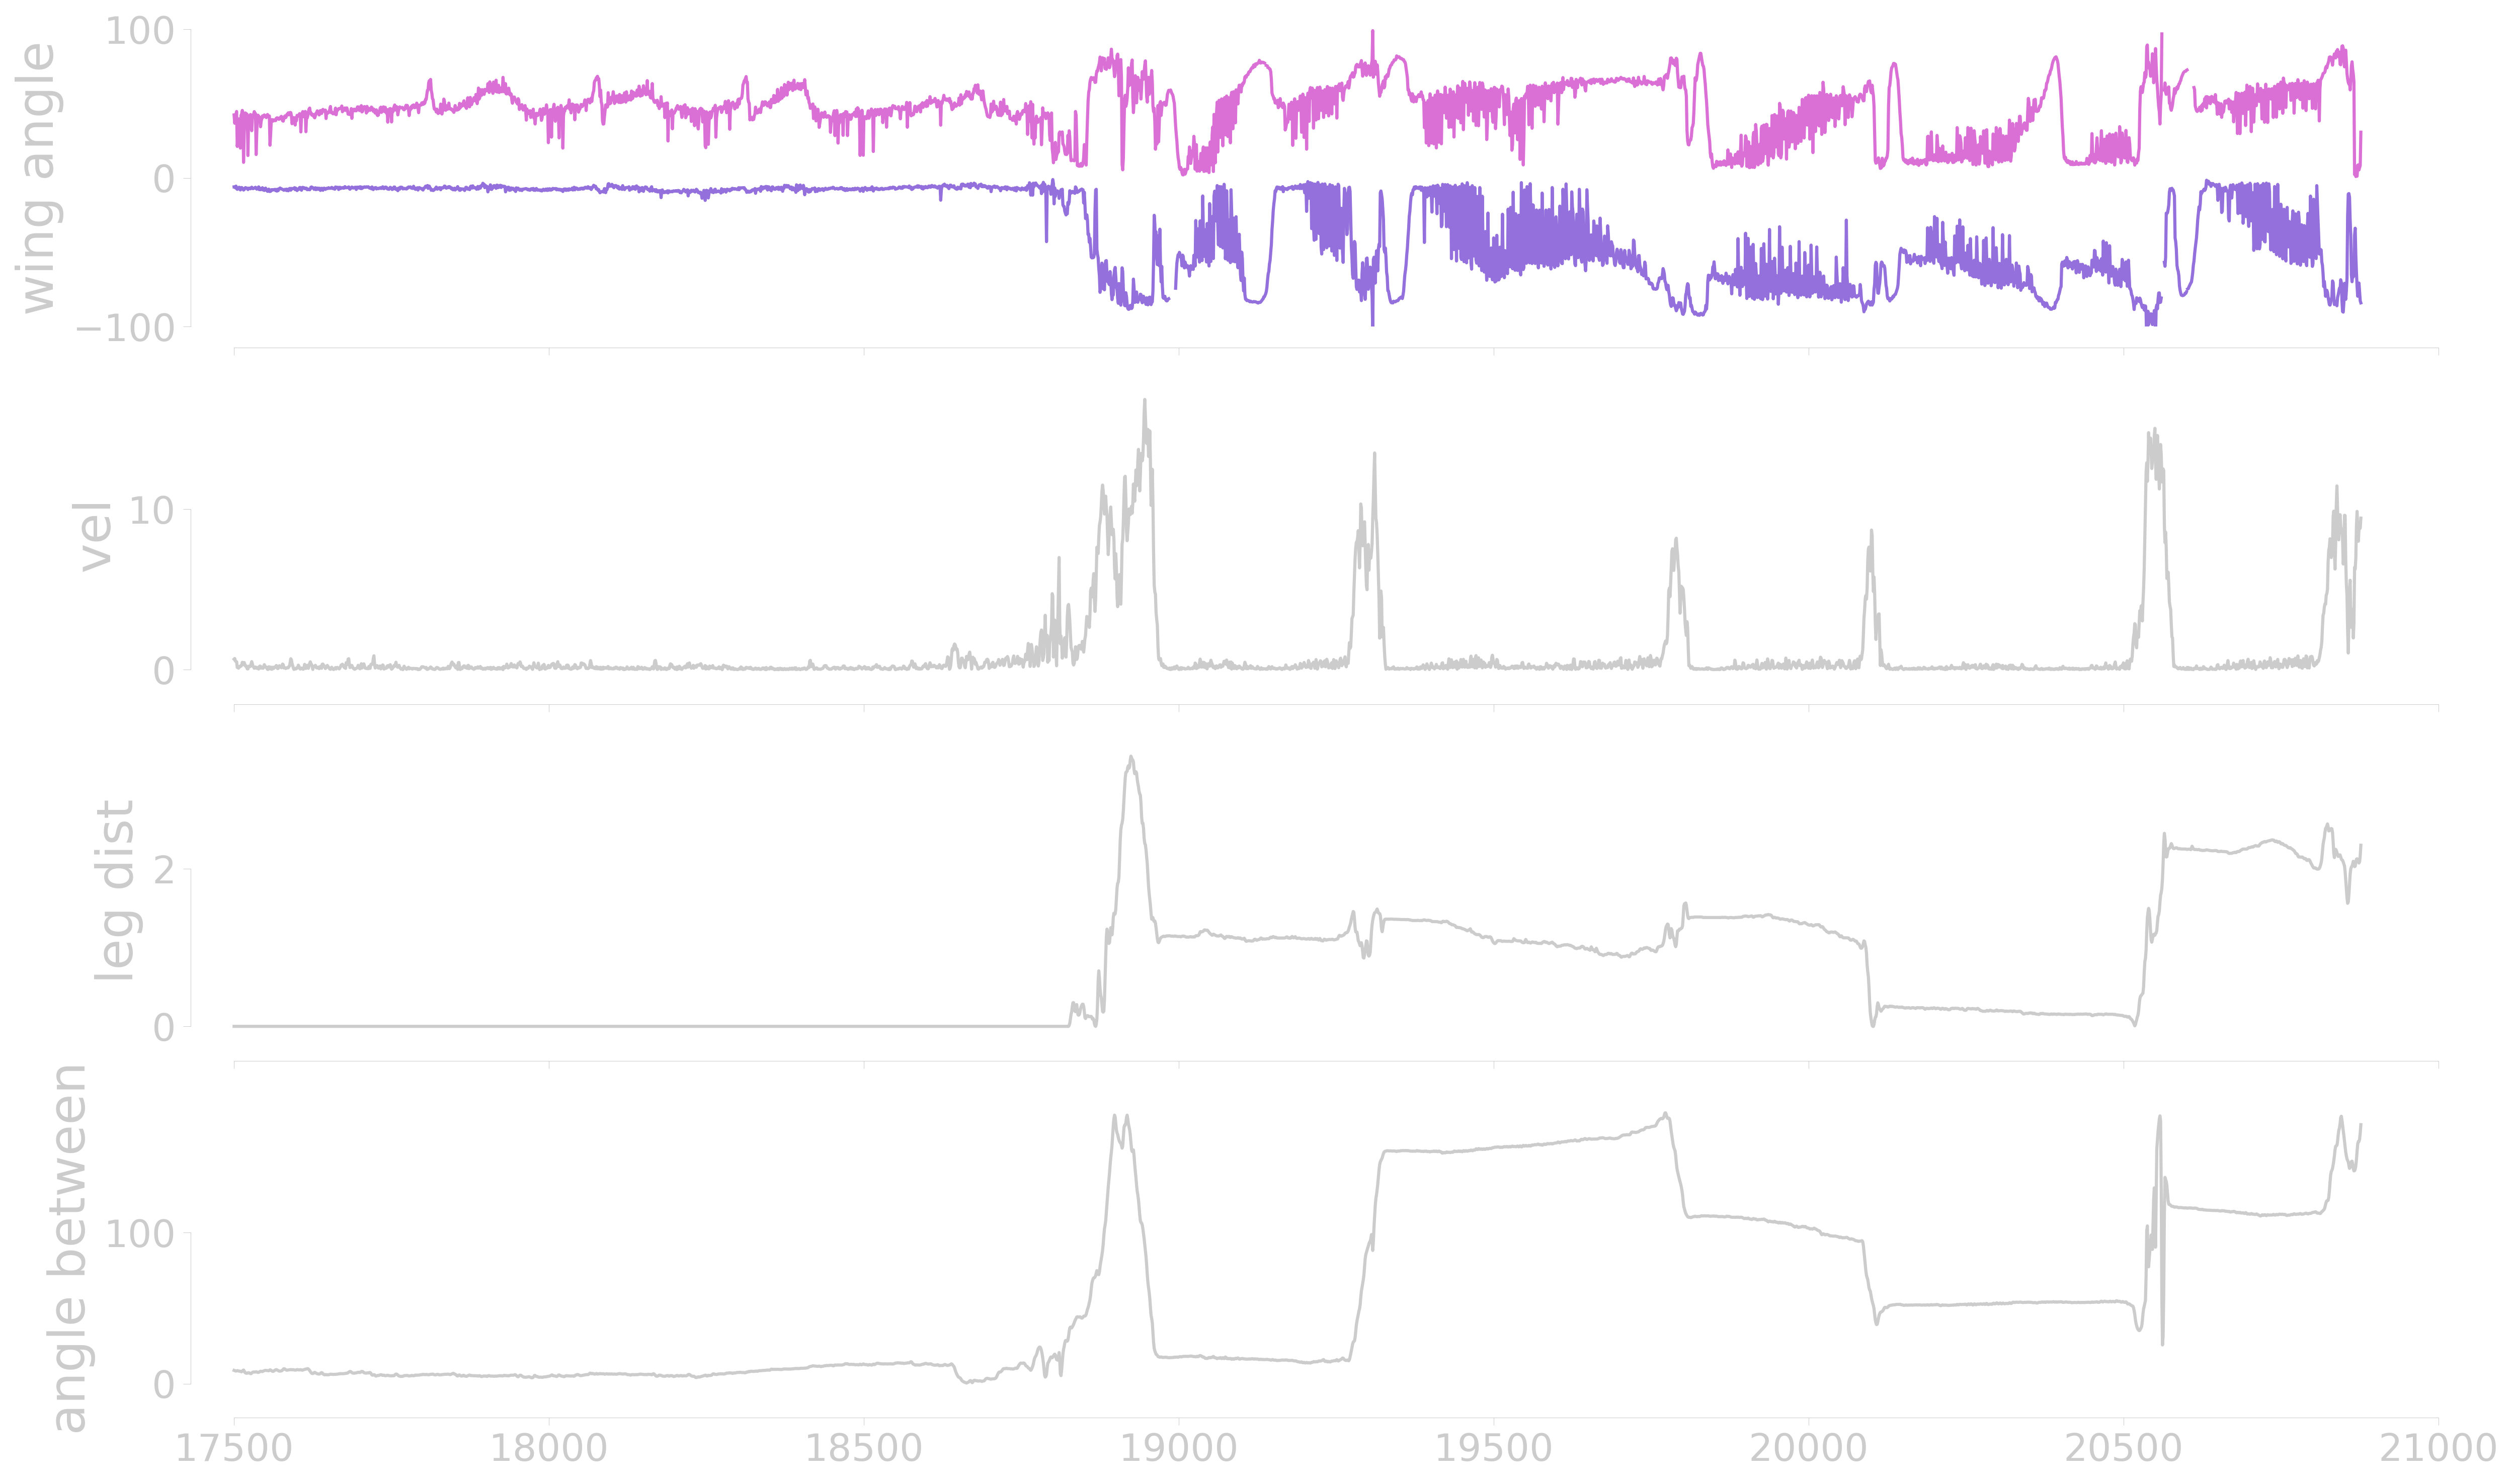

In [30]:
curr_bout= bouts[0]
print("start/end:", curr_bout[0], curr_bout[-1])
start_frame, end_frame = curr_bout[0], curr_bout[-1]
#end_frame=22000
xaxis='frame'

reg_color = [0.8]*3

# start_frame = 12400
# end_frame=14000
# 16402

start_frame=17500
end_frame=20877
fig, axn = pl.subplots(4, 1, figsize=(20,12), sharex=True)
ax=axn[0]
ax = plot_wing_extensions(trk, start_frame=start_frame, end_frame=end_frame, ax=ax, xaxis=xaxis, #figsize=(20,3),
                         c1=cdict['wing_l'], l1='wing_l', c2=cdict['wing_r'], l2='wing_r')
ax.set_ylim([-100, 100])
ax.set_ylabel('wing angle')

ax=axn[1]
ax.plot(feat.loc[start_frame:end_frame][xaxis], feat.loc[start_frame:end_frame]['vel'], color=reg_color)
ax.set_ylabel('vel')

ax=axn[2]
ax.plot(feat.loc[start_frame:end_frame][xaxis], feat.loc[start_frame:end_frame]['leg_dist'], color=reg_color)
ax.set_ylabel('leg dist')

ax=axn[3]
ax.plot(feat.loc[start_frame:end_frame][xaxis], feat.loc[start_frame:end_frame]['angle_between_deg'], color=reg_color)
ax.set_ylabel('angle between')

for ax in axn.flat:
    ax.patch.set_alpha(0)

sns.despine(trim=True, offset={'left': -30, 'bottom': 10})

# Create a little gif

In [31]:
import cv2
import matplotlib.gridspec as gridspec


In [32]:

def check_nan(wingR):
    if any(np.isnan(wingR)):
        wingR_ = pd.Series(wingR)
        wingR = wingR_.interpolate()
    return wingR

In [33]:
fmt='avi'
movie_path = os.path.join(acq_dir, '%s.%s' % (acquisition, fmt))
assert os.path.exists(movie_path), "Mov does not exist: %s" % movie_path


In [ ]:
# Movie cliip
# start_frame = 21136
# end_frame=22000

# start_frame = 14000
# end_frame=15000
print(start_frame, end_frame)
cap = cv2.VideoCapture(movie_path)
movie=[]
for fr in range(start_frame, end_frame):
    cap.set(1, fr)
    ret, frame = cap.read()
    movie.append(frame)
    

17500 20877


In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [ ]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

#### Test image

In [ ]:
# Data points to draw
wingL = np.rad2deg(trk.loc[start_frame:end_frame]['wing_l_ang'].values)
wingR = np.rad2deg(trk.loc[start_frame:end_frame]['wing_r_ang'].values)
wingR = check_nan(wingR)
wingL = check_nan(wingL)

vel = check_nan(feat.loc[start_frame:end_frame]['vel'].values)
leg_dist = check_nan(feat.loc[start_frame:end_frame]['leg_dist'].value)
angle_between = check_nan(feat.loc[start_frame:end_frame]['angle_between'].values)

tsec = trk.loc[start_frame:end_frame]['sec'].values - float(trk.loc[start_frame]['sec'])
tsec[0:5]

In [ ]:
fig = pl.figure(figsize=(15,6), constrained_layout=True)

spec = gridspec.GridSpec(ncols=8, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3]) # video
ax1 = fig.add_subplot(spec[0, 3:])  # wing extensions
ax2 = fig.add_subplot(spec[1, 3:])  # vel
ax3 = fig.add_subplot(spec[2, 3:])  # dist
ax4 = fig.add_subplot(spec[3, 3:])  # angle between

im = ax0.imshow(movie[0], aspect='equal', cmap='gray')
ax1.set_ylim([-100, 100])
ax1.set_ylabel('wing angle')
p1, = ax1.plot(wingL, color=cdict['wing_l'], lw=1)
p2, = ax1.plot(wingR, color=cdict['wing_r'], lw=1)

ax2.set_ylabel('vel')
p3, = ax2.plot(vel, color=reg_color)

ax3.set_ylabel('leg dist')
p4, = ax3.plot(leg_dist, color=reg_color)

ax4.set_ylabel('angle between')
p5, = ax4.plot(angle_between, color=reg_color)

for ax in fig.axes.flat:
    ax.patch.set_alpha(0)

sns.despine(trim=True, offset={'left': -30, 'bottom': 10})

In [38]:
project_dir = '/home/julianarhee/Documents/projects'
dst_dir = os.path.join(project_dir, 'flytracker-analysis', 'examples')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print("Saving output to: %s" % dst_dir )

Saving output to: /home/julianarhee/Documents/projects/flytracker-analysis/examples


In [ ]:
# Set playblack
nframes = len(movie) #start_frame
video_rate=20.
interval = (1./video_rate) * 1E3
nx, ny, _ = movie[0].shape

# fig = pl.figure(figsize=(20,6), dpi=300)
# spec = gridspec.GridSpec(ncols=9, nrows=5, figure=fig)
# ax0 = fig.add_subplot(spec[0:3, 0:3])
# ax1 = fig.add_subplot(spec[0:2, 3:])

# im = ax0.imshow(movie[0], aspect='equal', cmap='gray')
# p1, = ax1.plot(tsec[0], wingL[0], color=cdict['wing_l'], lw=2)
# p2, = ax1.plot(tsec[0], wingR[0], color=cdict['wing_r'], lw=2)
# ax1.set_ylim([-100, 100])
# ax1.set_xlim([0, tsec[-1]])

# def animate_with_movie(nframes, movie, x, p1_vals, p2_vals, video_rate, cdict):
# initialization function: plot the background of each frame
def init():
    im.set_data(np.zeros((nx, ny)))
    p1.set_data([], [])
    p2.set_data([], [])
    p3.set_data([], [])
    p4.set_data([], [])
    p5.set_data([], [])
    return (im, p1, p2, p3, p4, p5,)

# animation function. This is called sequentially
def update(i): #, im, movie, tsec, p1, p2, p1_vals, p2_vals):
#def animate(i):
    p1.set_data(tsec[:i], wingL[:i])
    p2.set_data(tsec[:i], wingR[:i])
    p3.set_data(tsec[:i], vel[:i])
    p4.set_data(tsec[:i], leg_dist[:i])
    p5.set_data(tsec[:i], angle_between[:i])
    im.set_data(movie[i])
    return (im, p1, p2, p3, p4, p5)

# call the animator. blit=True means only re-draw the parts that have changed.
#fargs = [im, movie, tsec, p1, p2, wingL, wingR]
anim = animation.FuncAnimation(fig, update, nframes, init_func=init, ##fargs=fargs, init_func=init, 
                        interval=interval, blit=True)

# anim = animate_with_movie(nframes, movie, tsec, wingL, wingR, video_rate, cdict)
outf = os.path.join(dst_dir, 'example-bout_%s.gif' % (acquisition))
#writervideo = animation.FFMpegWriter(fps=video_rate) 
writervideo = animation.PillowWriter(fps=video_rate) 
anim.save(outf, writer=writervideo)

print(outf)
anim

In [123]:
# anim.save(outf, writer='ffmpeg', fps=video_rate)
#outf = os.path.join(dst_dir, 'example-bout_%s.mp4' % (acquisition))
outf = os.path.join(dst_dir, 'example-bout_%s.gif' % (acquisition))

#writervideo = animation.FFMpegWriter(fps=video_rate) 
writervideo = animation.PillowWriter(fps=video_rate) 
anim.save(outf, writer=writervideo)


In [119]:
convert -version

NameError: name 'convert' is not defined

In [340]:
import sys

In [341]:
# !{sys.executable} -m pip install celluloid

In [343]:
from celluloid import Camera # getting the camera
from IPython.display import HTML


In [ ]:
outf = os.path.join(dst_dir, 'example-bout_%s.mp4' % (acquisition))

fig = pl.figure(figsize=(20,6))

spec = gridspec.GridSpec(ncols=9, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3])
ax1 = fig.add_subplot(spec[0:2, 3:])


camera = Camera(fig)
for i in range(len(movie)):
    x_t = tsec[:i] # current dataset
    y_t1 = wingL[:i] # current sine
    y_t2 = wingR[:i] # current sine
    frame=movie[i]
    ax0.imshow(frame, aspect='equal')
    ax1.plot(x_t, y_t1, c=cdict['wing_l'])
    ax1.plot(x_t, y_t2, c=cdict['wing_r'])
    camera.snap()
animation = camera.animate()
animation.save(outf) #'animation.mp4')
HTML(animation.to_html5_video())

In [345]:
HTML(animation.to_html5_video())

AttributeError: module 'matplotlib.animation' has no attribute 'to_html5_video'

In [349]:
from matplotlib.animation import FuncAnimation, PillowWriter


In [ ]:
outf = os.path.join(dst_dir, 'example-bout_%s.gif' % (acquisition))

fig = pl.figure(figsize=(20,6))

spec = gridspec.GridSpec(ncols=9, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3])
ax1 = fig.add_subplot(spec[0:2, 3:])

def animate(i):
#     ax.clear()
#     ax.set_xlim(-4,4)
#     ax.set_ylim(-4,4)
    im, = ax0.imshow(movie[i], aspect='equal')
    p1, = ax1.plot(tsec[0:i], wingL[0:i], c=cdict['wing_l'])
    p2, = ax1.plot(tsec[0:i], wingR[0:i], c=cdict['wing_r'])
    
#     line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
#     line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
#     point1, = ax.plot(x1[i], y1[i], marker='.', color='blue')
#     point2, = ax.plot(x2[i], y2[i], marker='.', color='red')
#     point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return im, p1, p2 #line, line2, line3, point1, point2, point3,
        
ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=864)    
ani.save(outf, dpi=300, writer=PillowWriter(fps=25))

In [347]:
end_frame- start_frame

864

In [232]:
print("start/end:", curr_bout[0], curr_bout[-1])


start/end: 3382 20877


In [250]:
acquisition

'20220202-1415_sant_7do_sh'

In [121]:
from itertools import groupby
from operator import itemgetter

In [122]:
feat1 = feat.copy()

In [125]:
# Get list of all bout chunks
courtship_ixs = feat1[feat1['courtship']].index.tolist()
bouts = []
for k, g in groupby(enumerate(courtship_ixs), lambda ix: ix[0]-ix[1]):
    bouts.append(list(map(itemgetter(1), g)))
fps = calib['FPS']
# print('FPS: %.2f Hz' % fps)

# Identify likely bout-stop false-alarms (i.e., next "bout" starts immediately after...)
curr_bout_ix = 0
combine_these=[curr_bout_ix]
bouts_to_combine={}
for i, b in enumerate(bouts[0:-1]):
    ibi = (bouts[i+1][0] - b[-1] ) / fps
    print(i, ibi)
    
    if ibi < ibi_min_sec: # check dur of next bout after current one
        if len(combine_these)==0:
            combine_these=[i]
        combine_these.append(i+1)
    else:
        if len(combine_these)==0:
            combine_these=[i]
        bouts_to_combine.update({curr_bout_ix: combine_these})
        curr_bout_ix+=1
        combine_these=[]
        
return bouts_to_combine


    
    
 

FPS: 40.00 Hz


In [167]:
bouts_to_combine

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8],
 1: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 2: [23, 24],
 3: [25, 26, 27],
 4: [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
 5: [46],
 6: [47],
 7: [48],
 8: [49, 50],
 9: [51, 52, 53, 54, 55, 56, 57, 58],
 10: [59, 60, 61]}

In [169]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [200]:
bout_dict={}
for bout_num, bout_ixs in bouts_to_combine.items():
    curr_ixs = flatten([bouts[i] for i in bout_ixs])
    bout_dict.update({bout_num: curr_ixs})
    dur = (curr_ixs[-1]-curr_ixs[0])/fps
    print(bout_num, dur)

0 437.375
1 414.175
2 133.025
3 51.075
4 272.425
5 2.525
6 21.75
7 147.025
8 42.225


In [199]:
bout_dict

{0: [3382,
  3383,
  3384,
  3385,
  3386,
  3387,
  3388,
  3389,
  3390,
  3391,
  3392,
  3393,
  3394,
  3395,
  3396,
  3397,
  3398,
  3399,
  3400,
  3401,
  3402,
  3403,
  3404,
  3405,
  3406,
  3407,
  3408,
  3409,
  3410,
  3411,
  3412,
  3413,
  3414,
  3415,
  3416,
  3417,
  3418,
  3419,
  3420,
  3421,
  3422,
  3423,
  3424,
  3425,
  3426,
  3427,
  3428,
  3429,
  3430,
  3431,
  3432,
  3433,
  3434,
  3435,
  3436,
  3437,
  3438,
  3439,
  3440,
  3441,
  3442,
  3443,
  3444,
  3445,
  3446,
  3447,
  3448,
  3449,
  3450,
  3451,
  3452,
  3453,
  3454,
  3455,
  3456,
  3457,
  3458,
  3459,
  3460,
  3461,
  3462,
  3463,
  3464,
  3465,
  3466,
  3467,
  3468,
  3469,
  3470,
  3471,
  3472,
  3473,
  3474,
  3475,
  3476,
  3477,
  3478,
  3479,
  3480,
  3481,
  3482,
  3483,
  3484,
  3485,
  3486,
  3487,
  3488,
  3489,
  3490,
  3491,
  3492,
  3493,
  3494,
  3495,
  3496,
  3497,
  3498,
  3499,
  3500,
  3501,
  3502,
  3503,
  3504,
  3505,
  350

In [183]:
bouts[]

0.175

In [126]:

    # identify where interbout is "too short"
    #ibi_min_sec = 0.5
interbout_sec = np.array([(bouts[i+1][0] - b[-1])/fps for i, b in enumerate(bouts[0:-1])])
    ibi_too_short = np.where(interbout_sec < ibi_min_sec)[0] # indexes into bouts
    

In [134]:
bouts[9][-10:] # bout 9 and 10 should be combined

# bout9:  21170 (ends)
# bout10: 21172 (starts)

[21161, 21162, 21163, 21164, 21165, 21166, 21167, 21168, 21169, 21170]

In [137]:
bouts[10][-5:]

[27809, 27810, 27811, 27812, 27813]

In [135]:
len(bouts), len(interbout_sec)

(65, 64)

In [138]:
ibi_too_short

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 49, 51, 52, 53, 54, 55, 56, 57, 59, 60,
       62, 63])

In [139]:
gap_starts = np.where(np.diff(ibi_too_short)>1)[0]
gap_starts

array([ 7, 20, 21, 23, 40, 41, 48, 50])

In [193]:
curr_bout_ix = 0
combine_these=[curr_bout_ix]
bouts_to_combine={}
for i, b in enumerate(bouts[0:-1]):
    ibi = (bouts[i+1][0] - b[-1] ) / fps
    print(i, ibi)
    
    if np.round(ibi) <= ibi_min_sec: # check dur of next bout after current one
        if len(combine_these)==0:
            combine_these=[i]
        combine_these.append(i+1)
    else:
        if len(combine_these)==0:
            combine_these=[i]
        bouts_to_combine.update({curr_bout_ix: combine_these})
        curr_bout_ix+=1
        combine_these=[]
        
#return bouts_to_combine

0 0.975
1 1.2
2 0.7
3 0.05
4 0.075
5 0.05
6 0.05
7 0.125
8 6.475
9 0.05
10 0.075
11 0.225
12 0.05
13 0.075
14 4.05
15 0.15
16 0.525
17 0.175
18 0.075
19 1.8
20 2.875
21 0.125
22 8.925
23 0.05
24 34.475
25 0.7
26 0.075
27 35.475
28 4.125
29 1.15
30 0.05
31 0.05
32 0.325
33 0.2
34 0.3
35 0.525
36 0.475
37 0.15
38 1.025
39 0.125
40 0.075
41 0.375
42 0.9
43 0.425
44 0.55
45 5.025
46 5.0
47 8.15
48 12.575
49 1.05
50 33.1
51 0.425
52 3.075
53 1.625
54 0.6
55 0.15
56 0.15
57 0.675
58 8.725
59 0.525
60 1.7
61 21.275
62 0.15
63 4.05


In [195]:
(bouts[48][0] - bouts[47][-1] ) / fps

8.15

In [186]:
(55401-55200)#/fps


201

In [161]:
bouts[22][-10:], bouts[23][0:5]

([37702, 37703], [38060, 38061, 38062, 38063, 38064])

In [166]:
bouts[27][-10:], bouts[28][0:5]

([46797, 46798, 46799, 46800, 46801, 46802, 46803],
 [48222, 48223, 48224, 48225, 48226])

In [162]:
(38060-37703)/fps


8.925

In [142]:
bouts[22][-10:], bouts[23][0:10]

([37702, 37703],
 [38060, 38061, 38062, 38063, 38064, 38065, 38066, 38067, 38068, 38069])

In [144]:
37702-37697

5

In [124]:

    # identify where interbout is "too short"
    #ibi_min_sec = 0.5
    ibi_too_short = np.where(interbout_sec < ibi_min_sec)[0] # indexes into bouts
    
    # get starting indices for true bouts
    gap_starts = np.where(np.diff(ibi_too_short)>1)[0]
    gap_ixs = [ibi_too_short[0]]
    gap_ixs.extend([ibi_too_short[i+1] for i in gap_starts])

    # concatenate too-short bouts into full bouts
    true_bouts=[]
    for i in gap_ixs:
        curr_ = bouts[i]
        curr_.extend(bouts[i+1])
        true_bouts.append(curr_)
    interbout_sec = np.array([(true_bouts[i+1][0] - b[-1])/fps for i, b in enumerate(true_bouts[0:-1])])
    ibi_too_short = np.where(interbout_sec < ibi_min_sec)[0] 
    assert len(ibi_too_short)==0, "Bad bout concatenation. Found %i too short" % len(ibi_too_short)

    # reassign courtship bouts:
    for bt in true_bouts:
        start, end = bt[0], bt[-1]

In [108]:
feat.loc[21160:21200][['courtship', 'facing_angle_deg']]

,courtship,facing_angle_deg
21160,True,2.006460
21161,True,4.382121
21162,True,7.018372
21163,True,49.478556
21164,True,133.541296
21165,True,132.614321
21166,True,45.331528
21167,True,2.518676
21168,True,4.708324
21169,True,6.651326


In [22]:

posM = trackdf[trackdf['id']==male_id][['pos_x', 'pos_y']]
posF = trackdf[trackdf['id']==female_id][['pos_x', 'pos_y']]

angle_between = np.rad2deg(featdf[featdf['id']==male_id]['angle_between']) # 0=facing the same dir (head-to-rear), pi=facing opposite dirs (rear-to-rear)
headingM = featdf[featdf['id']==male_id]['facing_angle']
headingF = featdf[featdf['id']==female_id]['facing_angle']



0    154.958924
1    154.672958
2    154.094972
3    153.840900
4    154.389388
Name: angle_between, dtype: float64

In [31]:
dists = pd.DataFrame(data=util.euclidean_dist(posM, posF, cols=['pos_x', 'pos_y']), columns=['distance'], index=posM.index)
dists.head()

,distance
0,292.475353
1,292.952202
2,295.149308
3,295.860121
4,295.132227


In [27]:
dists['interaction'] = False
dists.loc[dists['distance']<max_dist_to_other, 'interaction'] = True

array([292.47535303, 292.95220196, 295.1493082 , ..., 266.67161283,
       269.62774396, 273.64364835])

In [ ]:
feat = featdf[featdf['id']==fly_id].copy()
feat = util.threshold_courtship_bouts(feat, max_dist_to_other=max_dist_to_other, max_facing_angle=max_facing_angle)
feat.head()
trk = trackdf[trackdf['id']==fly_id].copy()
trk.loc[feat['facing_angle'].isna()] = np.nan

fps = calib['FPS']
trk['frame'] = trk.index.tolist()
trk['sec'] = trk['frame']/fps